In [9]:
#Import packages
using OrdinaryDiffEq, NODEData, Plots
using Flux, DiffEqSensitivity, Parameters
using Statistics


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664


In [36]:
function lotka_volterra(x,p,t)
        α, β, γ, δ = p 
        [α*x[1] - β*x[1]*x[2], -γ*x[2] + δ*x[1]*x[2]]
end
    
α = 1.3f0
β = 0.9f0
γ = 0.8f0
δ = 1.8f0
p = [α, β, γ, δ] 
tspan = (0.f0,50.f0)
dt = 0.1f0

x0 = [0.44249296f0, 4.6280594f0] 
    
prob = ODEProblem(lotka_volterra, x0, tspan, p) 
sol = solve(prob, Tsit5(), saveat=dt)

train, valid = NODEDataloader(sol, 10; dt=dt, valid_set=0.8)

(NODEData{Matrix{Float32},Int64} with 91 batches with length 10, NODEData{Matrix{Float32},Int64} with 390 batches with length 10)

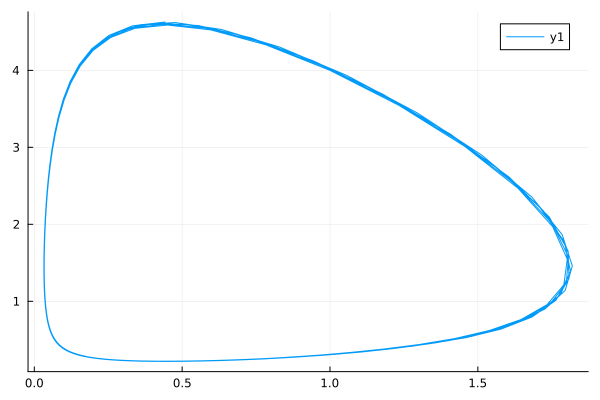

In [28]:
plot(sol[1,:], sol[2,:])

In [38]:
#Define ANN
N_WEIGHTS = 10 
nn = Chain(Dense(2, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 2))
p, re_nn = Flux.destructure(nn)

neural_ode(u, p, t) = re_nn(p)(u)
node_prob = ODEProblem(neural_ode, x0, (Float32(0.),Float32(dt)), p)

(Float32[-0.09233498, 0.65184253, -0.02010548, 0.65125453, 0.3146713, -0.5489348, -0.1275619, 0.6903002, 0.39677507, 0.42350122  …  -0.4251732, -0.6927687, 0.023491051, -0.33774117, -0.3937443, 0.53311396, 0.07685301, 0.42972133, 0.0, 0.0], Restructure(Chain, ..., 272))

In [60]:
abstract type AbstractChaoticNDEModel end 

"""
    ChaoticNDE{P,R,A,K} <: AbstractChaoticNDEModel

Model for setting up and training Chaotic Neural Differential Equations.

# Fields:

* `p` parameter vector 
* `prob` DEProblem 
* `alg` Algorithm to use for the `solve` command 
* `kwargs` any additional keyword arguments that should be handed over (e.g. `sensealg`)

# Constructor 

`ChaoticNDE(prob; alg=Tsit5(), kwargs...)`
"""
struct ChaoticNDE{P,R,A,K} <: AbstractChaoticNDEModel
    p::P 
    prob::R 
    alg::A
    kwargs::K
end 

function ChaoticNDE(prob; alg=Tsit5(), kwargs...)
    p = prob.p 
    ChaoticNDE{typeof(p), typeof(prob), typeof(alg), typeof(kwargs)}(p, prob, alg, kwargs)
end 

Flux.@functor ChaoticNDE
Flux.trainable(m::ChaoticNDE) = (p=m.p,)

function (m::ChaoticNDE)(X,p=m.p)
    (t, x) = X 
    Array(solve(remake(m.prob; tspan=(t[1],t[end]),u0=x[:,1],p=p), m.alg; saveat=t, m.kwargs...))
end

model = ChaoticNDE(node_prob)
model(train[1])

loss(x, y) = sum(abs2, x - y)
loss(model(train[1]), train[1][2]) 

η = 1f-3
opt = Flux.AdamW(η)
opt_state = Flux.setup(opt, model)

2×10 Matrix{Float32}:
 0.442493  0.33408  0.251695  0.190202  …  0.0718501  0.0599577  0.0514924
 4.62806   4.58279  4.46615   4.30134      3.44986    3.23062    3.0178

In [78]:
#Train model
η = 1f-3

loss_log = Float32[]
for epoch in 1:200
    if (epoch % 10) == 0 println("Epoch:", epoch) end
    losses = Float32[]
    for (i, data) in enumerate(train)
        t, x = data

        val, grads = Flux.withgradient(model) do m
            # Any code inside here is differentiated.
            # Evaluation of the model and loss must be inside!
            result = m((t,x))
            loss(result, x)
        end

        # Save the loss from the forward pass. (Done outside of gradient.)
        push!(losses, val)

        # Detect loss of Inf or NaN. Print a warning, and then skip update!
        if !isfinite(val)
            @warn "loss is $val on item $i" epoch
            continue
        end

    Flux.update!(opt_state, model, grads[1])
    end
    push!(loss_log, Statistics.mean(losses))

    if (epoch % 30) == 0  # reduce the learning rate every 30 epochs
        η /= 2
        Flux.adjust!(opt_state, η)
    end
end

Epoch:10
Epoch:20
Epoch:30
Epoch:40
Epoch:50
Epoch:60
Epoch:70
Epoch:80
Epoch:90
Epoch:100


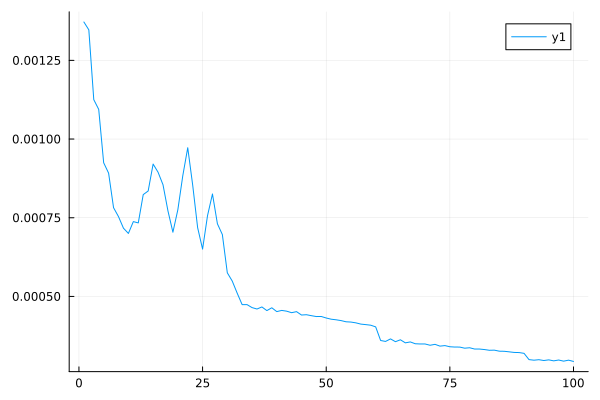

In [79]:
plot(loss_log)

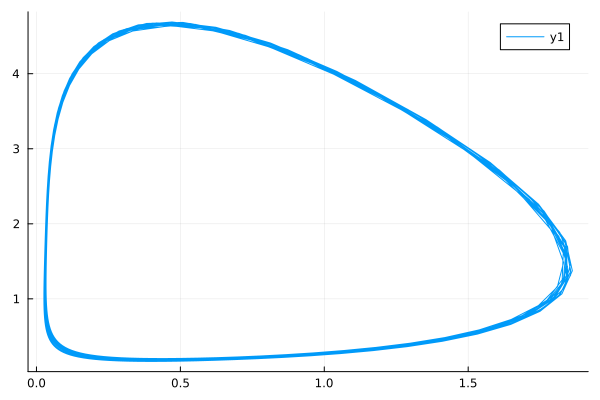

In [81]:
#Test model
t = convert(Array{Float32,1}, collect(0:0.1:100))
rec_sol = model((t,x0))
plot(rec_sol[1,:], rec_sol[2,:])